In [1]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import arm_sapr_tools
from copy import deepcopy
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda3/envs/houston/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Aim: To create a mathematically simple storm in a grid then project to a radar

In [2]:
xtest = np.linspace(-10000., 10000., 100)
nmaxtest = 1e3
width = 1000.0
x0test = 100.

$N = n_{max} e^{something}$

${\displaystyle f(x\mid \mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$
where

$ \mu$  is the mean or expectation of the distribution (and also its median and mode),
$ \sigma $ is the standard deviation, and
$ \sigma ^{2}$ is the variance.

In [3]:
divisor = np.sqrt(2.0 * np.pi * width**2.)
exp_divisor = 2.0*width**2.0
exp_numerator = (xtest - x0test)**2.0
N = (nmaxtest / divisor) * np.exp(-1.0 * (exp_numerator/exp_divisor))

Text(0,0.5,'Drop density ($m^{-3}$)')

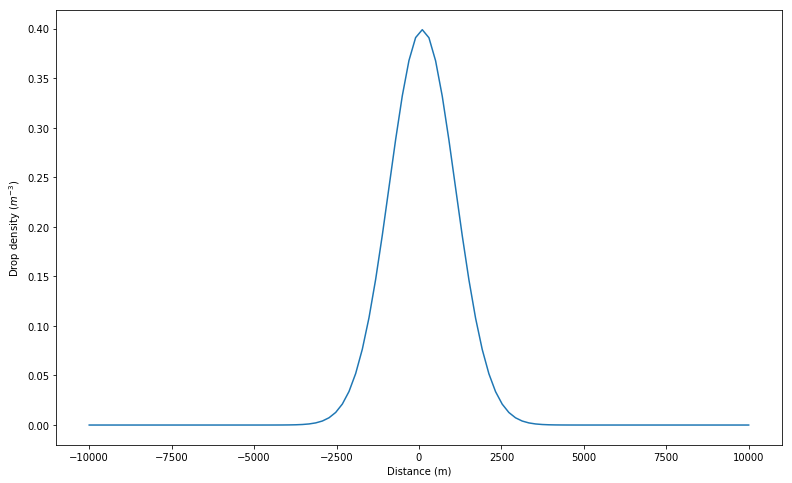

In [11]:
fig = plt.figure(figsize = [13,8])
plt.plot(xtest, N)
plt.xlabel("Distance (m)")
plt.ylabel("Drop density ($m^{-3}$)")

Lets look in height.. we want N to be constant until we hit FZL and then decrease to zero by width + flz


In [75]:
nhts = 201
ztest = np.linspace(0,20.0*1000.0, nhts)
fzltest = 5.0*1000.0
sclw_depthtest = 2000.0

slope = sclw_depthtest

intercept = sclw_depthtest + fzltest
decay_func = np.clip((-ztest + intercept) / sclw_depthtest, a_min=0, a_max=1)


Text(0,0.5,'height weighting (unitless)')

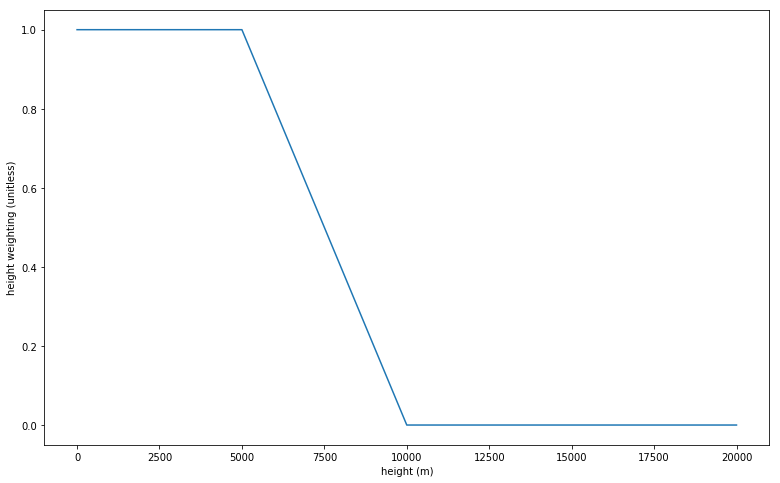

In [74]:
fig = plt.figure(figsize = [13,8])
plt.plot(ztest, decay_func)
plt.xlabel("height (m)")
plt.ylabel("height weighting (unitless)")

In [4]:
def storm_values(x,y,z, radius=1000.0, fzl=4000.0, sclw_depth = 1000.0, x0 = 0.0, y0 = 0.0, Nmax = 1e3):
    """
    Return values for an isolated synthetic storm. A normal distrubution in x and y and 
    tapering to zero between the freezing level and super cooled liquid water depth
    
    Parameters
    ----------
    x, y, z: float
    The location where storm values are to be calculated. In meters.
    
    radius: float
    radius of the storm in meters
    
    fzl: float
    Height of the freezing level in meters
    
    sclw_depth: float
    how high above the freezing level can we expect super cooled liquid water?
    
    x0, y0: float
    Location of the center of the storm
    
    Nmax:
    maximum drop density (per cubic meter)
    
    Returns
    -------
    N: float
    mean drop size diameter in  m^-3
    
    """
    #X and Y
    distance_from_center = np.sqrt((x-x0)**2 + (y-y0)**2)
    divisor = np.sqrt(2.0 * np.pi * radius**2.)
    exp_divisor = 2.0*radius**2.0
    exp_numerator = (distance_from_center)**2.0
    
    #height
    slope = sclw_depth
    intercept = sclw_depth + fzl
    decay_func = np.clip((-z + intercept) / sclw_depth, a_min=0, a_max=1)

    N = decay_func * (Nmax ) * np.exp(-1.0 * (exp_numerator/exp_divisor))
    return N

In [104]:
nptsx = 301
nptsy = 301
nptsz = 201

edges = 15.*1000.
top = 20.*1000.

x_coord = np.linspace(-edges, +edges, nptsx)
y_coord = np.linspace(-edges, +edges, nptsy)
z_coord = np.linspace(0., top, nptsz)

dx = xr.DataArray(x_coord, dims='x')
dy = xr.DataArray(y_coord, dims='y')
dz = xr.DataArray(z_coord, dims='z')

gx, gy, gz =xr.broadcast(dx, dy, dz)


In [144]:
funcy_me = storm_values(gx, gy, gz, radius = 5000.0, sclw_depth=5000.0, fzl=4000.)
da = xr.DataArray(funcy_me, dims=['x', 'y', 'z'], 
                  coords={'x':x_coord, 'y':y_coord, 'z':z_coord})

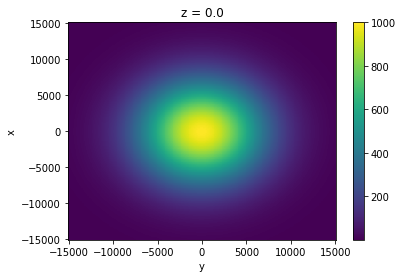

In [145]:
da[:,:,0].plot.pcolormesh()

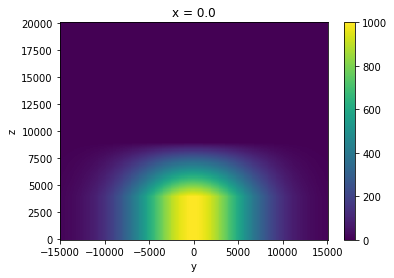

In [146]:
da[150,:,:].transpose().plot.pcolormesh()

In [118]:
houston_radar = pyart.io.read('/data/houston/data/20170101/KHGX_sur_20170101.154633.nc')

In [122]:
z_fld = deepcopy(houston_radar.fields['reflectivity'])

my_x, my_y, my_z = houston_radar.get_gate_x_y_z(0)

In [147]:
z_fld = deepcopy(houston_radar.fields['reflectivity'])
for sweep in houston_radar.sweep_number['data']:
    print(sweep)
    my_x, my_y, my_z = houston_radar.get_gate_x_y_z(sweep)
    my_n = storm_values(my_x, my_y, my_z, 
                        x0=45000., y0=45000.,fzl=4000.0, sclw_depth=4000.,
                       radius=10000.)
    i1 = houston_radar.sweep_start_ray_index['data'][sweep]
    i2 = houston_radar.sweep_end_ray_index['data'][sweep]
    z_fld['data'][i1:i2] = my_n[0:-1]
houston_radar.add_field('number', z_fld, replace_existing=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


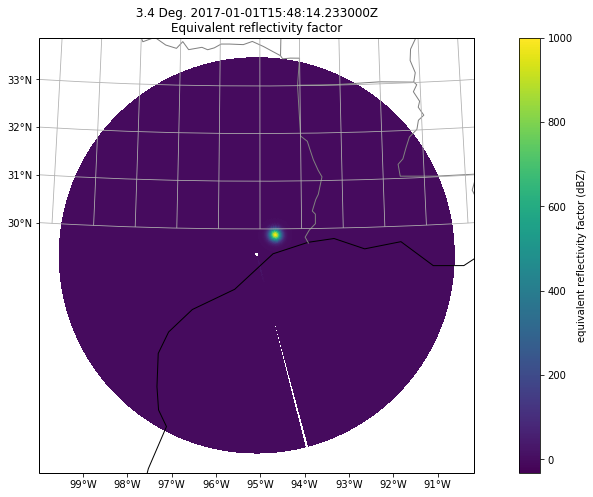

In [150]:
plt.figure(figsize=[16,8])
my_disp = pyart.graph.RadarMapDisplayCartopy(houston_radar)
my_disp.plot_ppi_map('number', 5, vmax= 1e3)

In [133]:
my_x

array([[  1524.88827907,   1704.27040589,   1883.64872718, ...,
        323613.6973797 , 323786.4184462 , 323959.18703536],
       [  1547.14009452,   1729.13950137,   1911.13608272, ...,
        328330.63926745, 328505.85315223, 328681.11525881],
       [  1569.36150714,   1753.97520071,   1938.58545516, ...,
        333048.75635515, 333226.50231669, 333404.27273419],
       ...,
       [  1452.30976086,   1623.15397744,   1793.99456379, ...,
        308142.00475563, 308306.42958063, 308470.89973918],
       [  1475.82178595,   1649.43148949,   1823.03777337, ...,
        313123.20973376, 313290.3249748 , 313457.41717817],
       [  1499.11938433,   1675.4697624 ,   1851.81666607, ...,
        318056.5275939 , 318226.22502796, 318395.9692751 ]])

In [7]:
def test_center_of_storm():
    assert storm_values(0., 0., 0., Nmax=1) == 1.0

def test_above_storm():
    assert storm_values(0., 0., 10000., fzl=100., sclw_depth=100.) == 0.0

In [6]:
test_s()

In [8]:
test_above_storm()

ModuleNotFoundError: No module named 'pytmatrix'